# Data simulation
Let's simulate a dataset that will help us solve the challenge.
We know that the actual average duration of each trip is 100 days. 
We also know from previous conversations that the trip duration follows a lognormal distribution.  If we did not have that information we would have assumed an exponential distribution. 
According to the statement, we only know the date on which each RPC leaves IFCO. It is not detailed in the statement, but logically I understand that the trip ends when the RPC is returned to IFCO and becomes available again. I understand that after the end of the trip the asset can stay some days until it is rented again. I assume that these days are not considered as part of the trip. In order to generate a meaningful dataset, we will also generate the return date.

I also assume the following:
- We will assume for example a maximum of 20 days at most of an RPC in the pool waiting to be rented again for the sole purpose of generating a consistent dataset.
- We will assume that we have all the assets from the beginning and that up to the moment of the analysis the lost ones have not been replaced.  
- To generate the dataset we will assume the business started in January 1st, 2020


In [77]:
import pandas as pd
import numpy as np
import random
from datetime import datetime , timedelta
import matplotlib.pyplot as plt


In [ ]:
## Assumptions to help data simulation
num_rpc = 5000
max_days_in_pool = 20
business_start =  datetime(2020,1,1)
mean = 100 # this parameter is known
sigma = 0.3
lost_prob = 0.01

In [79]:
# generate RPC unique id
rpc_ids = [i for i in range(num_rpc)]


In [ ]:
def generate_rentals(rpc_id):
    rental_periods = []
    rental_dates = []
    returning_dates = []

    rental_date = business_start + timedelta(days=np.random.randint(0,max_days_in_pool))

    while rental_date < datetime.today():
  
        lost = random.random() < lost_prob
        if lost:
            returning_date = pd.NaT
            rental_duration = np.nan
        else:
            rental_duration = int(np.random.lognormal(mean=np.log(mean), sigma=sigma))
            returning_date = rental_date + timedelta(days=rental_duration)

        rental_dates.append(rental_date)
        returning_dates.append(returning_date)
        # If one RPC is lost we will not travel anymore
        if lost: 
            break
        rental_date = returning_date + timedelta(days=np.random.randint(0,max_days_in_pool))
        
    return rental_dates, returning_dates

In [81]:

# Generate dataset
data = []

for id in rpc_ids:
    rental_dates, returning_dates = generate_rentals(id)
    data.extend([(id, rental_date, returning_date) for rental_date, returning_date in zip(rental_dates, returning_dates)])

# Create DataFrame
df = pd.DataFrame(data, columns=["rpc_id", "rental_date", "returning_date"])

# All those with returning date > today should have returning date null
df.loc[df['returning_date'] > datetime.today(), 'returning_date'] = pd.NaT

# Shuffle rows to make the dataset less structured
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few rows
print(df.head(20))

    rpc_id rental_date returning_date
0      890  2021-09-26     2021-12-27
1     3286  2020-08-20     2020-12-15
2      378  2021-01-24     2021-05-27
3     1512  2020-05-15     2020-09-06
4     4867  2020-04-01     2020-07-03
5     4196  2023-04-11     2023-07-28
6      587  2024-02-21     2024-07-13
7     2376  2020-10-29     2021-03-10
8     4112  2022-05-19     2022-08-17
9      405  2022-05-18     2022-09-03
10      73  2022-01-25     2022-05-29
11     931  2022-02-17     2022-05-29
12    4929  2022-01-15     2022-05-11
13    2954  2024-05-23     2024-08-20
14     605  2024-01-26     2024-06-11
15    3499  2023-01-14     2023-06-14
16     977  2023-03-30     2023-07-24
17     944  2023-01-28     2023-04-24
18    2534  2024-06-23            NaT
19    4324  2024-09-28            NaT


The following code cells are just for validation purposes.

In [82]:
#trip duration
df['trip_duration_days'] = (df['returning_date'] - df['rental_date']).dt.days


In [83]:
df.head(20)

,rpc_id,rental_date,returning_date,trip_duration_days
0,890,2021-09-26,2021-12-27,92.0
1,3286,2020-08-20,2020-12-15,117.0
2,378,2021-01-24,2021-05-27,123.0
3,1512,2020-05-15,2020-09-06,114.0
4,4867,2020-04-01,2020-07-03,93.0
5,4196,2023-04-11,2023-07-28,108.0
6,587,2024-02-21,2024-07-13,143.0
7,2376,2020-10-29,2021-03-10,132.0
8,4112,2022-05-19,2022-08-17,90.0
9,405,2022-05-18,2022-09-03,108.0


In [84]:
df[df['returning_date'].isna()]['rpc_id'].nunique()

4625

In [88]:
df_sorted = df.sort_values(by=['rpc_id', 'rental_date'])
df_sorted.head(20)

,rpc_id,rental_date,returning_date,trip_duration_days
36388,0,2020-01-11,2020-03-25,74.0
45901,0,2020-04-01,2020-08-14,135.0
66715,0,2020-08-23,2020-10-29,67.0
10513,0,2020-10-31,2021-01-22,83.0
57968,0,2021-01-25,2021-06-01,127.0
54741,0,2021-06-12,2021-09-07,87.0
57177,0,2021-09-12,2021-12-27,106.0
65560,0,2022-01-07,2022-04-26,109.0
19853,0,2022-04-27,2022-07-14,78.0
59891,0,2022-07-30,2022-10-16,78.0


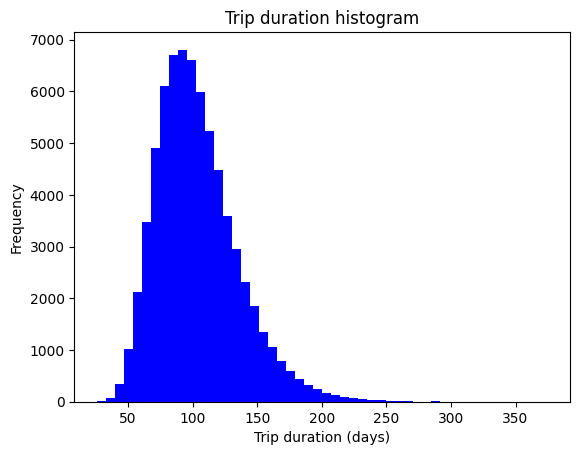

In [87]:
plt.hist(df['trip_duration_days'], bins = 50, color = 'blue')

plt.title("Trip duration histogram")
plt.xlabel("Trip duration (days)")
plt.ylabel("Frequency")

plt.show()